# Task06 PageRank

## 1 PageRank冷知识

- PageRank是Google最早的搜索引擎算法，给每个网页重要度打分，高分靠前
- 1997年之前的搜索引擎：网页收录少，相关率20%，排序效果差
- 1997年之后，斯坦福大学Google搜索结果，相关率80%
- PageRank申请专利后，谷歌一举超越雅虎、微软
- 斯坦福大学拥有超过1%的Google股票，收益超过10亿美元

## 2 PageRank简介

- PageRank算法的作者：Larry Page、Sergey Brin

### 2.1 互联网的图表示

- Web Pages表示为Nodes，Hyperlinks表示为Edges
- 把互联网当作一个整体的系统，网页之间存在关联，而不是孤立的个体
- 网页可以表示成导航连接式网页

- 无标度网络（Scale-Free）呈现幂律分布

### 2.2 PageRank算法概述

- PageRank使用连接信息计算节点的重要度
- 理解PageRank的5个角度：迭代求解线性方程组、迭代左乘M矩阵、矩阵的特征向量、随机游走、马尔可夫链

- 迭代求解线性方程组：重要节点引出的稀少链接，权重更高
    - 假设网页$i$的重要度为$r_i$，出度为$d_i$，则每一条链接的投票为$\displaystyle \frac{r_i}{d_i}$
    - 网页$j$的重要度为所有入度链接的投票值之和$\displaystyle r_j = \sum_{i \rightarrow j} \frac{r_i}{d_i}$

- 迭代左乘M矩阵：将重要度写成矩阵的形式，左乘重要度矩阵
    - 假设网页$i$的出度为$d_i$，则从网页$i$指向网页$j$，矩阵$\displaystyle M_{ji} = \frac{1}{d}$，该矩阵（column stochastic matrix）每列求和为1
    - 所有网页的PageRank值求和为1
    - 迭代$\vec{r} = M \cdot \vec{r}$

- 矩阵的特征向量：
    - 通过不断地迭代左乘M矩阵，会稳定收敛，即得到M矩阵的主特征向量
    - 收敛性：根据Perreon-Frobenius定理，对于Column Stochastic矩阵，最大的特征值为1，存在唯一的主特征向量（特征值1对应的特征向量），向量所有元素求和为1

- 随机游走：随机游走每个网页，计数求和之后再归一化成每个网页的概率，即PageRank值
    - 假设在$t$时刻，一个用户访问了多个网页$i$（$i_1,i_2,\cdots$）
    - 在$t+1$时刻，访问到网页$j$的概率为$\displaystyle r_j = \sum_{i \rightarrow j} \frac{r_i}{d_i}$
    - 如果无限游走，$p(t)$可表示为网页$i$的概率，这个概率表示用户在$t$时刻访问网页$i$的PageRank值
    - 逐渐迭代，可以稳定收敛，即$p(t+1) = M \cdot p(t) = p(t)$

- 马尔可夫链：每个节点表示一种状态，节点之间的连接表示状态的转移，根据状态转移矩阵，可以计算下一个时刻的状态转移概率

### 2.3 求解PageRank

- 推荐方式：迭代左乘M矩阵（幂迭代）

- 计算方法：
$$
r_j^{(t+1)} = \sum_{i \rightarrow j} \frac{r_i^{(t)}}{d_i}
$$
当$\displaystyle \sum_i |r_i^{(t+1)} - r_i^{(t)}| < \varepsilon$时，达到了收敛程度

- 计算步骤：
    1. Initialize：$r^{(0)} = [1/N, \cdots, 1/N]^T$
    2. Iterate：$\displaystyle r^{(t+1)} = M \cdot r^{(t)} \Longleftrightarrow r_j^{(t+1)} = \sum_{i \rightarrow j} \frac{r_i^{(t)}}{d_i}$
    3. Stop when $|r^{(t+1)} - r^{(t)}|_1 < \varepsilon$

### 2.5 PageRank收敛性分析

- Ergodic定理：如果满足irreducible（不可约的）和aperiodic（非周期震荡）的马尔科夫链，则一定满足：
    1. 存在唯一的解$\pi$
    2. 能从$\pi_0$收敛到$\pi$

- 存在两个节点：Spider trap（自己指向自己的节点）、Dead end（死胡同节点）
    - 当概率为$\beta$时，正常随机游走
    - 当概率为$1-\beta$时，有一定的概率随机传送到任何一个节点

- PageRank解决方案：
$$
r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1-\beta) \frac{1}{N}
$$
其中，$\beta$称为阻尼系数。  
    
    可以等价改写成Google Matrix：
    $$
    G = \beta M + (1 - \beta) \left[ \frac{1}{N} \right]_{N \times N}
    $$

## 3 应用案例

- 寻找与指定节点最相似的节点（Proximity on graphs）：同一个用户访问过的节点更可能是相似的（基本假设）

- 优化：将“随机传送到任一节点”优化为“随机传送到指定的一些节点”或“随机传送到指定的一个节点”，用访问次数来反映节点的亲疏远近。

- PageRank变种：
    - Topic-Specific PageRank或Personalized PageRank：随机传送到指定的一些节点
    - Random Walk with Restarts：随机传送到指定的一个节点

## 4 代码实战

### 4.1 导入工具包

In [1]:
import networkx as nx
import numpy as np 
import random
import pandas as pd

# 数据可视化
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

### 4.2 加载数据，并构建图

In [2]:
# 西游记人物数据集
df = pd.read_csv('data/journey_to_the_west/triples.csv')

In [3]:
edges = [edge for edge in zip(df['head'], df['tail'])]

G = nx.DiGraph()
G.add_edges_from(edges)

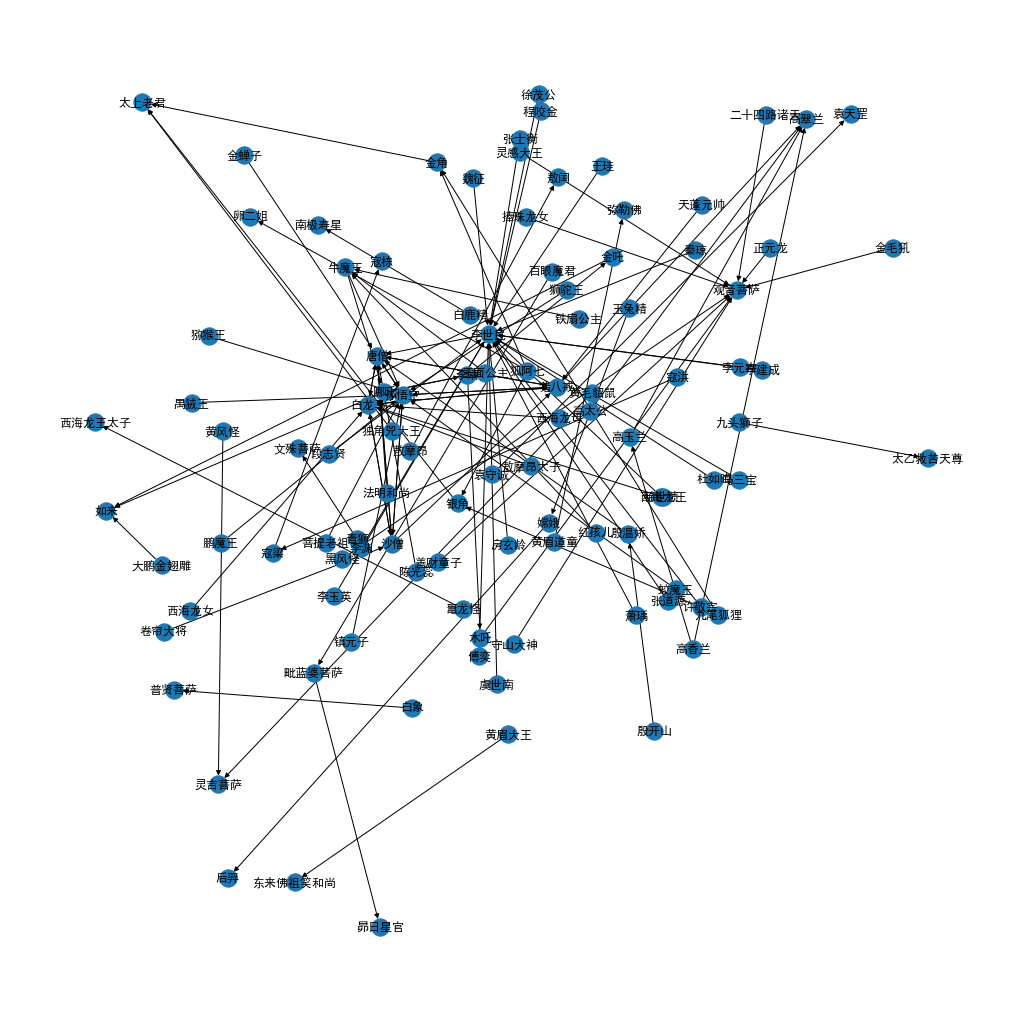

In [5]:
# 可视化
plt.figure(figsize=(14,14))
pos = nx.spring_layout(G, iterations=3, seed=5)
nx.draw(G, pos, with_labels=True)
plt.show()

### 4.3 计算每个节点PageRank重要度

In [10]:
pagerank = nx.pagerank(
    G,                     # NetworkX graph 有向图，如果是无向图则自动转为双向有向图
    alpha=0.85,            # Damping Factor
    personalization=None,  # 是否开启Personalized PageRank，随机传送至指定节点集合的概率更高或更低
    max_iter=100,          # 最大迭代次数
    tol=1e-06,             # 判定收敛的误差
    nstart=None,           # 每个节点初始PageRank值      
    dangling=None,         # Dead End死胡同节点
)

In [11]:
# 按PageRank值从高到低排序
pagerank_sorted_values = sorted(pagerank.items(),key=lambda x : x[1], reverse=True)

In [12]:
pagerank_sorted_values[:5]

[('唐僧', 0.13349105557884888),
 ('孙悟空', 0.10498354112014094),
 ('白龙马', 0.09531260474698808),
 ('猪八戒', 0.09247797536009736),
 ('沙僧', 0.07627154154696374)]

### 4.4 用节点尺寸可视化PageRank值

In [13]:
# 节点尺寸
node_sizes = (np.array(list(pagerank.values())) * 8000).astype(int)

In [14]:
# 节点颜色
M = G.number_of_edges()
edge_colors = range(2, M + 2)

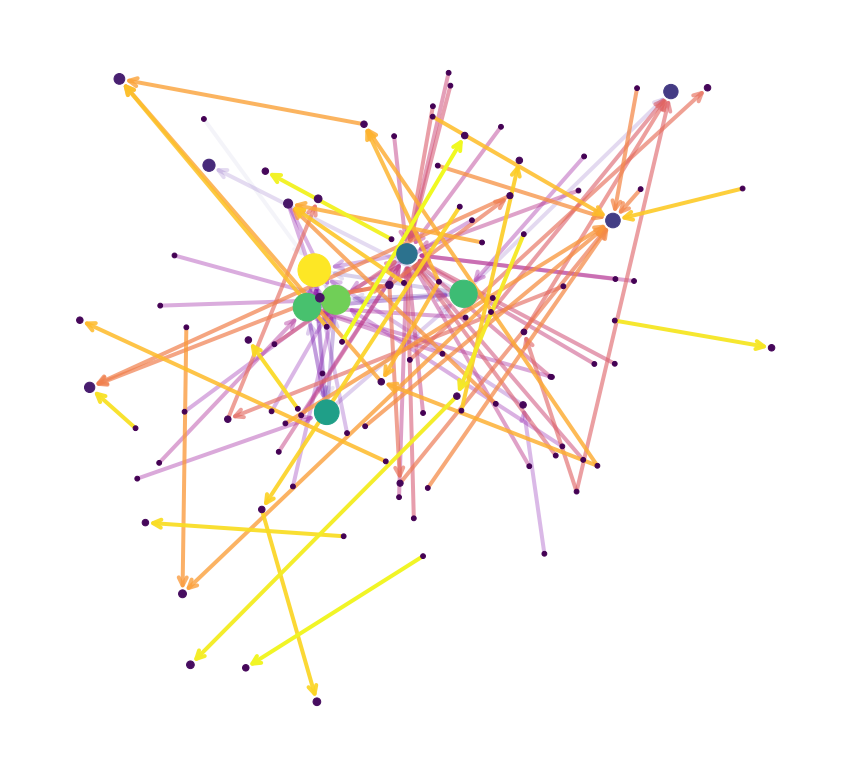

In [15]:
plt.figure(figsize=(15,14))

# 绘制节点
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_sizes)

# 绘制连接
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,   # 节点尺寸
    arrowstyle="->",        # 箭头样式
    arrowsize=20,           # 箭头尺寸
    edge_color=edge_colors, # 连接颜色
    edge_cmap=plt.cm.plasma,# 连接配色方案，可选：plt.cm.Blues
    width=4                 # 连接线宽
)

# 设置每个连接的透明度
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

# # 图例
# pc = mpl.collections.PatchCollection(edges, cmap=cmap)
# pc.set_array(edge_colors)
# plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

## 5 本章总结

本次任务，主要讲解了PageRank相关内容，包括：

- PageRank简介：PageRank是Google最早的搜索引擎算法，给每个网页重要度打分，高分靠前；主要使用迭代左乘M矩阵（幂迭代）方式，加入阻力系数，避免遇到Spider trap（自己指向自己的节点）和Dead end（死胡同节点），还可以优化为“随机传送到指定的一些节点”或“随机传送到指定的一个节点”。
- PageRank代码实战：使用西游记人物数据集，构建有向图，计算每个节点PageRank重要度，并进行可视化展示。